# DCNet - A simple LSTM-RNN for generating sequence consensus
We will explore building a long short term memory (LSTM) for consensus sequence generation. We will train a model to learn the patterns in simulated noise sequences and then use this model to generate the consensus sequence.

# 1. Dependencies
First, we need some boilerplate code to load the PyTorch and other modules.

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random


torch.manual_seed(42)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from matplotlib import pyplot as plt
%matplotlib inline

# 2. Dataset
Generate a random sequence of length 220 as our original teamplate sequences.

In [2]:
seq = [random.choice(["A","C","G","T"]) for _ in range(220)]
print("".join(seq))
# convert the `seq` to a PyTorch tensor

AGAATTAGCAGGCATTTAGTAAACCTAGGCAAAAGAGTTCCATAAAGAGACGACTTCCTAGGTTGAACTTGTCTTAGTGGAGAAACCGCTGCCGCAATACCGGACCTTCCGAGACCCATTCCGGGTGATAGTGTGGCAGATCTCGAAGTGATGGGATGCGCATCCCGATCGACCTCTCGCATAAGAAATCTCCACCGATCTCTCATATAGCGCATCCAAA


We define a couple utility functions for encoding DNA bases to vectors and simulate sequencing errors.

In [3]:
def sim_error(seq, pi=0.05, pd=0.05, ps=0.01):
    """
    Given an input sequence `seq`, generating another
    sequence with errors. 
    pi: insertion error rate
    pd: deletion error rate
    ps: substitution error rate
    """
    out_seq = []
    for c in seq:
        while 1:
            r = random.uniform(0,1)
            if r < pi:
                out_seq.append(random.choice(["A","C","G","T"]))
            else:
                break
        r -= pi
        if r < pd:
            continue
        r -= pd
        if r < ps:
            out_seq.append(random.choice(["A","C","G","T"]))
            continue
        out_seq.append(c)
    return "".join(out_seq)

In [4]:
bmap = {"A":0, "C":1, "G":2, "T":3}
def one_hot(b):
    t = [[0,0,0,0]]
    i = bmap[b]
    t[0][i] = 1
    return t

print("one-hot encoding for DNA bases")
print("A:", one_hot("A"))
print("C:", one_hot("C"))
print("G:", one_hot("G"))
print("T:", one_hot("T"))

one-hot encoding for DNA bases
A: [[1, 0, 0, 0]]
C: [[0, 1, 0, 0]]
G: [[0, 0, 1, 0]]
T: [[0, 0, 0, 1]]


In [5]:
seq_t = Variable(torch.FloatTensor([one_hot(c) for c in seq])).cuda()

Simulate 20 erroneous sequences with insertion error at 5%, deletion errors at 5% and subsitution error at 1%.

In [6]:
seqs = [sim_error(seq, pi=0.05, pd=0.05, ps=0.01) for _ in range(20)]
seqs_t = [Variable(torch.FloatTensor([one_hot(c) for c in s])).cuda()  for s in seqs]
seqs

['ACAATTAGAGGCATTAGTAAACCTAAGCAAAGAGTTCCATAAAGAGACGACTTCCGAGGTTGAACTTGTCTTAAGTGGAGAAAACCGTCTGCCGAATACCGGACCTTCCGTAGACCCATTCCGGGTGATAGTGTGGCAGACTCGAGTGATGGGATGCGGCATCCTCGATCCGACCCTCCCGCATACAGAAATCCCACCGATCTCTCATATGAGCGCATCCAAA',
 'AAAGTAGCAGGCAGTTTAGTAACCTAGGTCAAAAGAGTCCATAAAGAGACGTACTTCCTAGGTTGAACTTGTCTAGTGGAGAATACCGCTGCCGCAAATACCGGACCTCTCCGAGACCCATTCCGGGTGAAGTGTGGCAGATCTCGAAGAGTGCATGGATGTCGCATCCCGATCGACCTCCTCGGCATAAGAAATCTCCACACCGATCTCTCATATAGCGCATCCAA',
 'AGGAATAGCGGGCTTTAGTAAACCTAGGCAAAAAGAGTTCCATAAGAAGACGACTCCGTAGGTTGAGATTTGTCCCTTAGGGGAGAAACCGTGCCGGCAATACCGGACCTTCCGAGACCCATTCCGGGTGATAGTGTGGCAGATGCTCGAGTAGATGGGATGCGCATCCCGACTGACCTCTCGCATAAGAATTCCACAACTCTCATTATAGCGCATCCCAAA',
 'AGAATTAGCAGGCACTTTAGAACCTAGGCAAAAGAGTTCCATAAAAGAGACGACCTTCCTAGGTTGAACTGTCTTAGTGGAGAAACCGTGACGAATACCGGACCTTCCGAGACCCATTCCCGGGTGATAGTGTCGCAGTATCCGAAGTGATGGGCATGCGCATCCCGATCGACTCTCGCATAAGAAATCTCCACCGATCTCGTCTTATACTGCATGCCAAA',
 'AGAATTAGCAGGCATTAAGTAAACTAGGCCAACAAGAGTTCCATAAAGAGACGACTTCCAGGTTGAACTTTTCTTAGTGGAGAAA

# 3. Model construction
Here we define the simple DCNet class as subclass of `torch.nn.Module`.

Fill in the TODOs to define the RNN model within the build_model function.

In [7]:
class DCNet(nn.Module):

    def __init__(self, hidden_dim, layer1_dim, layer2_dim):
        super(DCNet, self).__init__()
        self.hidden_dim = hidden_dim
        
        '''TODO: One LSTM layer that needs to specify the input demension, hidden layer demension, as well as the number of recurrent layers.
        Here, we use a four demensional one-hot encoding as the input.'''
        self.lstm = nn.LSTM(input_size = 4, hidden_size = hidden_dim, num_layers = 1) 
        
        # Two fully connected layers with ReLU as activation function
        self.linear1 = nn.Linear(in_features = hidden_dim, out_features = layer1_dim)
        self.relu1 = nn.ReLU()
        '''TODO: add the second fully connected layer with ReLU as the activation function'''
        self.linear2 = nn.Linear(in_features = layer1_dim, out_features = layer2_dim)
        self.relu2 = nn.ReLU()
        
        
        # Output layer
        '''TODO: specify the output demension.
        Here, the input is a vector of four demension'''
        self.linear3 = nn.Linear(in_features = layer2_dim, out_features = 4)
        
        # Weight initialization
        self.hidden_init_values = None
        self.hidden = self.init_hidden()
        nn.init.xavier_uniform(self.linear1.weight)
        nn.init.xavier_uniform(self.linear2.weight)
        nn.init.xavier_uniform(self.linear3.weight)
        
    def init_hidden(self):
        if self.hidden_init_values == None:
            self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
                                       autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
        return self.hidden_init_values

    # Forward process
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        tmp1 = self.relu1(self.linear1(lstm_out.view(len(seq), -1)))
        tmp2 = self.relu2(self.linear2(tmp1))
        _out = self.linear3(tmp2)
        base_out = _out
        return base_out


Initialize the DCNet. You can use different parameters to initilize the model. 

In [8]:
'''TODO: initialize the neurons in hidden layers. such as 32 in LSTM layer, and 12 neurons in each fully connetcted layers'''
dcnet = DCNet(hidden_dim = 50, layer1_dim = 20, layer2_dim = 40)

# Set the gradients manually to zero
dcnet.zero_grad()
dcnet.cuda()
# Initial the paramerters in the DCNet
dcnet.hidden = dcnet.init_hidden()
for name, param in dcnet.named_parameters():
    if 'bias' in name:
        nn.init.constant(param, 0.0)
    elif 'weight' in name:
        nn.init.xavier_normal(param)

/users/PAS1475/lzqian8023/.conda/envs/bmi8050/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/users/PAS1475/lzqian8023/.conda/envs/bmi8050/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/users/PAS1475/lzqian8023/.conda/envs/bmi8050/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/users/PAS1475/lzqian8023/.conda/envs/bmi8050/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  del sys.path[0]
/users/PAS1475/lzqian8023/.conda/envs/bmi8050/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  # This is added back by InteractiveShel

# 4. Training the model: loss and training operations
Set up the loss function and SGD optimizer.

In [9]:
# Use mean square error as the loss function. You can use mean absolute error as the loss function by the function nn.L1Loss()  
# loss_function = nn.L1Loss()
loss_function = nn.MSELoss()

'''TODO: Initilize the leaning rate as 0.1'''
lr = 0.1

# Use stochastic gradient descent to train the model
optimizer = optim.SGD(dcnet.parameters(), lr=lr)

The following loop train the DCnet using the noisy sequences. We also lowe the learning rate `lr` every 250 epoches

In [10]:
range_ = (1, 200)
# Mini-batch: a subset of the training set that is used to evaluate the gradient of the loss function and update the weights. 
mini_batch_size = 5

# One epoch: an entire dataset is passed forward and backward through the neural network exactly one time. 
'''TODO: change the epoch to 2001'''
for epoch in range(750):
    for i in range(int(len(seqs_t)/mini_batch_size)):
        loss = 0
        s, e = range_
        for seq2 in random.sample(seqs_t, mini_batch_size):
            dcnet.hidden = dcnet.init_hidden()
            dcnet.zero_grad()
            seq2 = seq2[s-1:e]
            seq_ = seq2.view(-1,4)
            out = dcnet(seq_)
            loss += loss_function(out[:-1], seq_[1:])
        loss.backward()
        optimizer.step()
    if epoch % 250==0:
        print("epoch:", epoch, "loss:", loss.cpu().data/mini_batch_size, "learning rate:", lr)
        
        # Use a decreasing learning rate to converge to the optimal value. 
        '''TODO: the decreasing rate is set to 0.95 '''
        lr *= 0.95
        optimizer = optim.SGD(dcnet.parameters(), lr=lr)

epoch: 0 loss: tensor(0.1910, device='cpu') learning rate: 0.1
epoch: 250 loss: tensor(0.1739, device='cpu') learning rate: 0.095
epoch: 500 loss: tensor(0.1621, device='cpu') learning rate: 0.09025


# 5. Result visualization 
We can visualize the input and output tensors after we send the whole original template into the DCNet to reconstruct the output tensor. 

In [11]:
import numpy as np
dcnet.hidden = dcnet.init_hidden()
xout = dcnet(seq_t[:250])
x1 = xout[:-1].cpu().data.numpy() 
xx1=np.transpose(seq_t[1:250,0,:].data.cpu().numpy())
xx2=np.transpose(x1)

The following code snippet using DCNet to generate a consensus sequence with only the first base in the template. 

In [12]:
dcnet.hidden = dcnet.init_hidden()
base_t= Variable(torch.FloatTensor([one_hot(seq[0])])).cuda()

consensus = []

for _ in range(201):
    xout = dcnet(base_t)
    next_t = [0,0,0,0]
    next_t[np.argmax(xout.cpu().data.numpy())]=1
    consensus.append(next_t)
    base_t= Variable(torch.FloatTensor([next_t])).cuda()
consensus = np.array(consensus)
consensus = consensus.transpose()

Let's compare the generated consensus to the original template. 

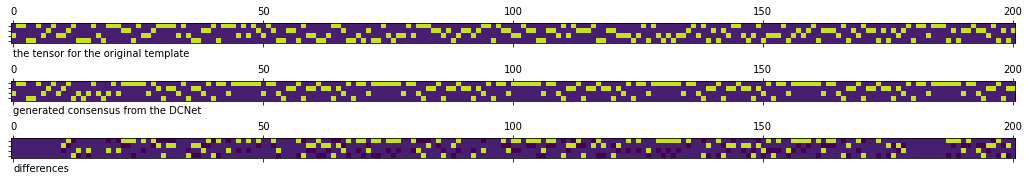

In [13]:
plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(consensus, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"generated consensus from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(consensus-xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

The cell below plots three matrices. The first one is from the original template. The second one is the reconstruction from the the DCNet using the first base in the template as input. The third one is the differences between the two matrices. If we have generate the consensus perfectly matching the original template, the elements of the third matrix will be all zeros.